In [1]:
"""環境"""
# .lab

"""更新履歴"""
# 最終更新日：2025/05/21
# 2025/05/21 shutilを使って、cachedirを洗浄することにしました
# 2025/05/15 simple_progress_barおよびdata(dict)を使い始めました。
# 2025/02/25 os.getcwd()を採用し、__file__を定義する必要をなくしました。

"""モジュール読み込み"""
# ファイル操作等
import sys
import os
# from datetime import datetime
from pprint import pprint
import logging
# import pickle
# import struct
from tqdm import tqdm
import h5py
# import threading
import json

# tkinter
from tkinter import filedialog, messagebox, Tk

# データ分析ツール
import pandas as pd
import numpy as np
import scipy as sp
# import math
# from sklearn.linear_model import LinearRegression

# グラフ等作成用
import matplotlib
import matplotlib.pyplot as plt         # 図の作成用
from PIL import Image as im
# import cv2
from IPython.display import display, HTML, clear_output, update_display, Image

# 自作モジュール
sys.path.append(r"C:\Users\okaza\pythonenv")
from modules.Mytools.Tools import print_fileinfo, h5_tree, dict_tree, simple_progress_bar, clean_cache_except_logfiles, get_total_size
import modules.Mytools.Settings
import modules.fitXRD as fx
from modules.peakfit import peakfit, pseudoVoigt

"""ログ管理ツール作成"""
# chche directoryの設定
cachedir = os.path.abspath(os.getcwd() + "/.cache")
clean_cache_except_logfiles(cachedir)
os.makedirs(cachedir, exist_ok=True)

# loggerの作成
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
format = "%(levelname)-9s  %(asctime)s [%(filename)s:%(lineno)d] %(message)s"

# Streamハンドラクラスを作成
sh = logging.StreamHandler()
sh.setLevel(logging.DEBUG)
sh.setFormatter(logging.Formatter(format))
logger.addHandler(sh)

# Fileハンドラクラスをインスタンス化
logfile = cachedir + ""
fh = logging.FileHandler(filename=cachedir + "/notebook.log", encoding="utf-8")
fh.setLevel(logging.DEBUG)
fh.setFormatter(logging.Formatter(format))
logger.addHandler(fh)
logger.debug("[Activate workspace]: " + os.getcwd())
logger.debug("[Set cache]: "+ os.path.abspath(cachedir))
logger.debug("[Activate log]: " + os.path.abspath(cachedir + "/notebook.log"))

# globalなデータを作成
data = dict()
logger.debug("[Create global variable]: data")

DEBUG      2025-06-27 10:02:08,230 [388102471.py:71] [Activate workspace]: c:\Users\okaza\pythonenv\lf\twocolor
DEBUG      2025-06-27 10:02:08,231 [388102471.py:72] [Set cache]: c:\Users\okaza\pythonenv\lf\twocolor\.cache
DEBUG      2025-06-27 10:02:08,232 [388102471.py:73] [Activate log]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\notebook.log
DEBUG      2025-06-27 10:02:08,232 [388102471.py:77] [Create global variable]: data


## 目的

二色法で温度を計算します。生データの強度でマスクをかけます。

## 1. ファイル読み込み

In [2]:
from modules.SpeReadPy.read_spe import SpeReference

生データを読み込みます。

In [3]:
def read_spe():

    # spe生データ
    spefile = r"C:\Users\okaza\Box\DataStrorage\SPring8-2025-04\Okazaki\mDIH07\LF_4\mDIH08  09.spe"


    if True: # [ Main ]
        # データ読み込み
        spe = SpeReference(spefile)
        logger.info("[File]: " + os.path.abspath(spefile))

        # データ格納
        key = sys._getframe().f_code.co_name
        hdffile = os.path.join(cachedir, key+".hdf")
        data[key] = dict()
        data[key]["hdffile"] = hdffile
        with h5py.File(hdffile, mode = "w") as f:
            f.create_dataset(
                name = "data",
                data = spe.get_data()[0],
                dtype = np.float64
            )
            f.create_dataset(
                name = "wavelength",
                data = spe.get_wavelengths()[0],
                dtype = np.float64
            )
            h5_tree(f)
        logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
        dict_tree(data)

    return
read_spe()
del read_spe

INFO       2025-06-27 10:02:20,362 [3045064853.py:10] [File]: C:\Users\okaza\Box\DataStrorage\SPring8-2025-04\Okazaki\mDIH07\LF_4\mDIH08  09.spe
INFO       2025-06-27 10:02:21,622 [3045064853.py:29] [Add variables]: read_spe (data = 0.00 MB)


<HDF5 file "read_spe.hdf" (mode r+)>
├── data ((201, 400, 1340), float64)
└── wavelength ((1340,), float64)

└── read_spe
    └── hdffile <class 'str'>

校正データを読み込みます。

In [4]:
def add_calib():

    # ランプデータ
    spectrumdata = r"C:\Users\okaza\pythonenv\twocolors\ReferenceData\OL245C.csv"

    # フィルターデータ
    standard_up = r"C:\Users\okaza\Box\DataStrorage\SPring8-2025-05\CeO2\Tcalib_BLAZE_20250514\standard\0_Up_std.spe"
    standard_down = r"C:\Users\okaza\Box\DataStrorage\SPring8-2025-05\CeO2\Tcalib_BLAZE_20250514\standard\0-Down_std.spe"

    if True: # [ Main ]
        
        # 補正データの読み込み
        std_data = dict()
        std_data["OD"] = dict()
        std_data["OD"]["up"] = SpeReference(standard_up).get_data()[0][0]
        std_data["OD"]["down"] = SpeReference(standard_down).get_data()[0][0]
        std_data["spectrum"] = dict()
        std_data["spectrum"]["csvdata"] = pd.read_csv(spectrumdata).values.T
        logger.debug("[Load]: std_data")

        # データ格納
        key = sys._getframe().f_code.co_name
        data[key] = std_data
        logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
        dict_tree(data)

    return
add_calib()
del add_calib

DEBUG      2025-06-27 10:02:37,677 [210197429.py:19] [Load]: std_data
INFO       2025-06-27 10:02:37,678 [210197429.py:24] [Add variables]: add_calib (data = 0.00 MB)



├── read_spe
│   └── hdffile <class 'str'>
└── add_calib
    ├── OD
    │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
    │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
    └── spectrum
        └── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]

## 2. 強度・波長マスク

In [5]:
import matplotlib.animation as anim

生データの強度からマスクをかけます。

DEBUG      2025-06-27 10:05:48,071 [3977165439.py:90] [Save fig]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\hist_intsty.png
INFO       2025-06-27 10:05:48,072 [3977165439.py:99] [Add variables]: hist_intsty (data = 102.75 MB)


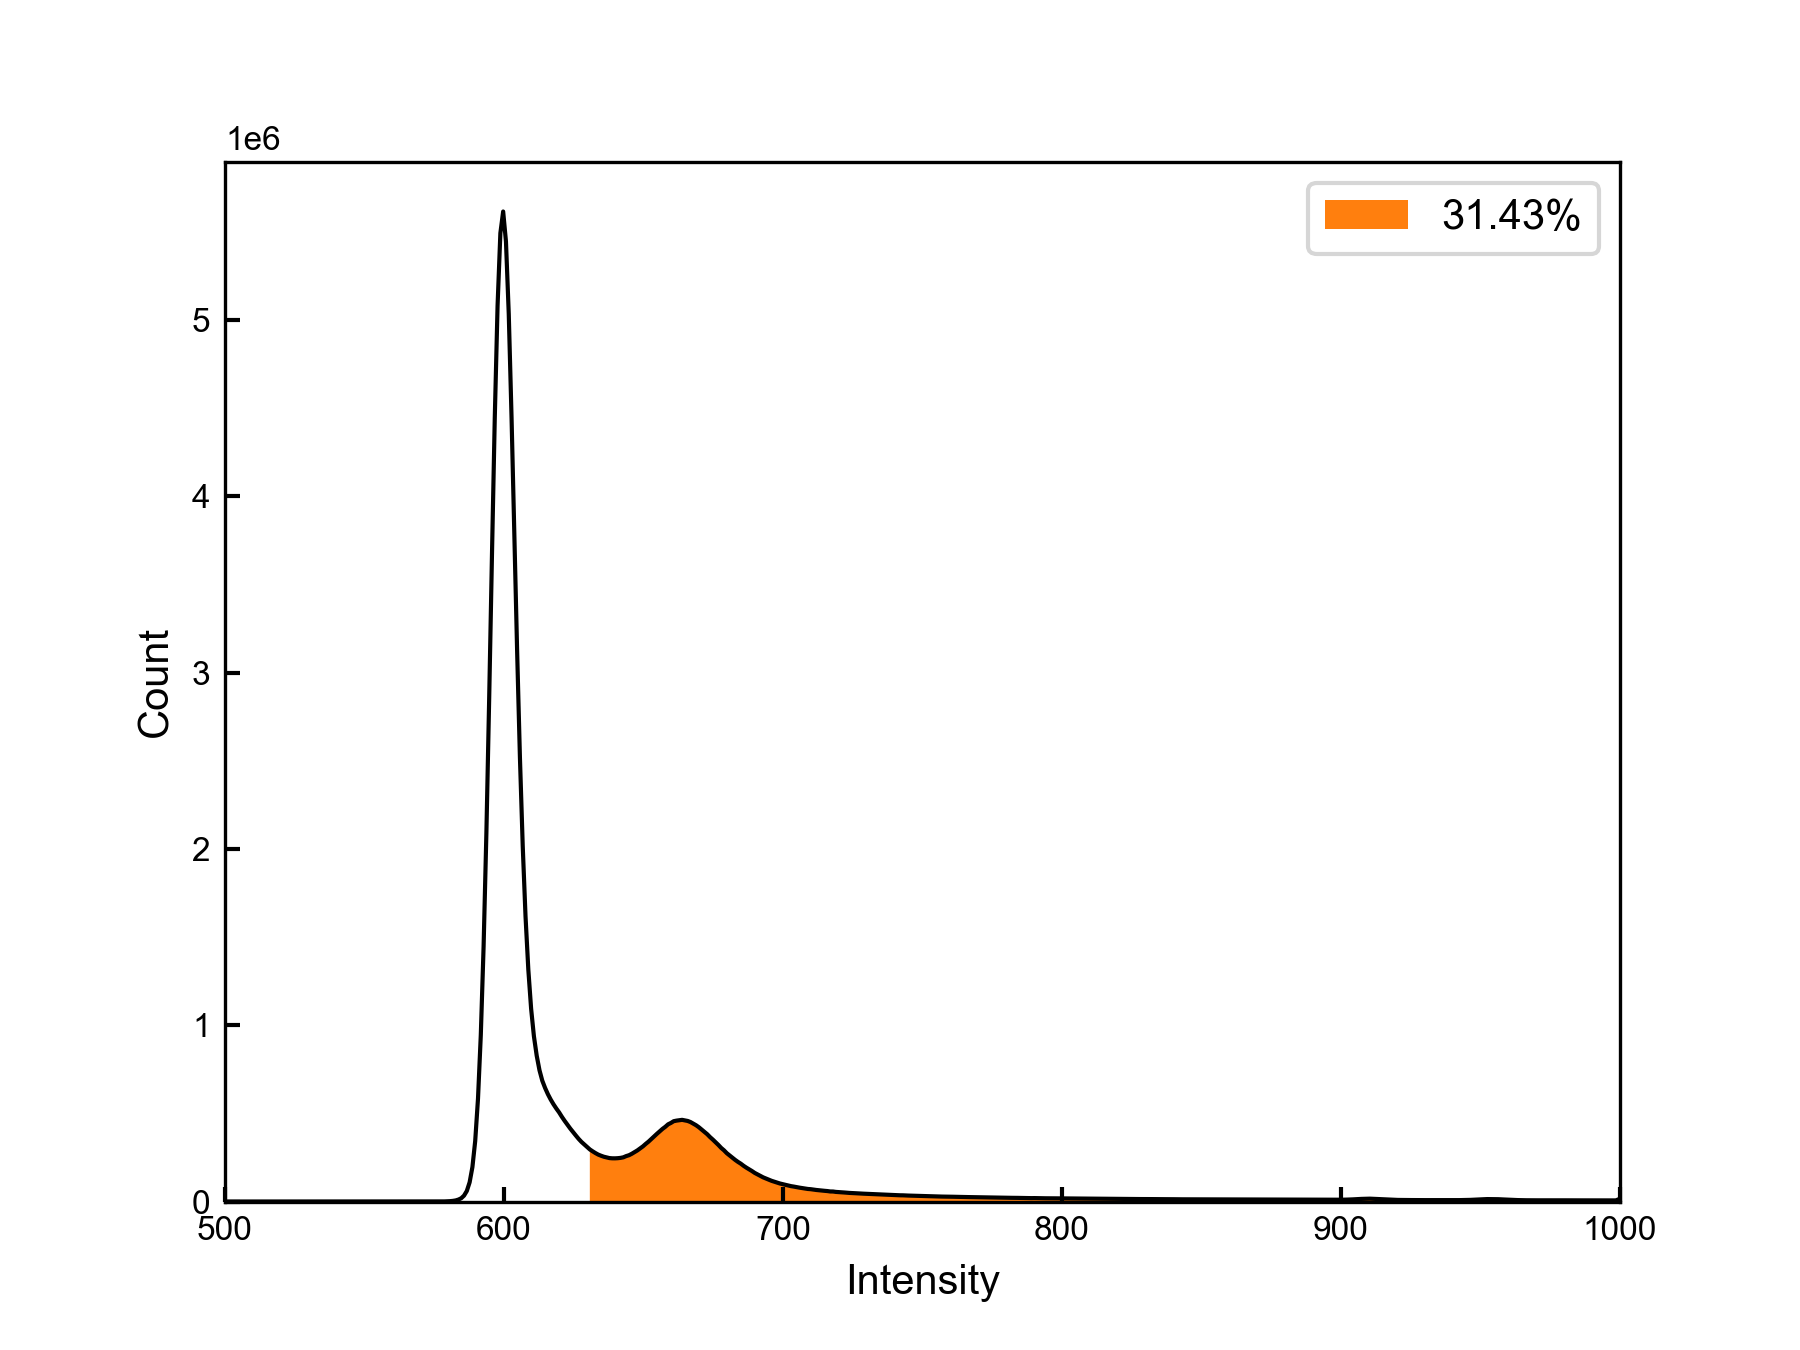


├── read_spe
│   └── hdffile <class 'str'>
├── add_calib
│   ├── OD
│   │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
│   │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
│   └── spectrum
│       └── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]
├── hist_intsty
│   └── threshold <class 'tuple'>
├── sum_wavelength
│   └── range <class 'tuple'>
└── make_mask_intsty
    └── mask <class 'numpy.ndarray'> [shape = (201, 400, 1340)]

In [17]:
def hist_intsty():

    # 強度範囲 (optional)
    # ilim = (0, 100)
    ilim = (500, 1000)
    # ilim = (1000, 25000)
    # ilim = (800, 30000)
    # ilim = (500, 25000)
    # ilim = (15000, 25000)
    # ilim = (0,1000)

    # ヒストグラムのステップ (optional)
    # step = 200

    # 閾値
    intsty_threshold = (630, 40000)
    # intsty_threshold = (600, 40000)

    if True:

        # データ読み込み
        with h5py.File(data["read_spe"]["hdffile"], mode = "r") as f:
            intsty = np.array(f["data"][()]) # type: ignore

        # 例外処理
        if not ("ilim" in locals()):
            ilim = (
                float(intsty.min()),
                float(intsty.max())
            )
        if not ("step" in locals()):
            step = int(ilim[1] - ilim[0])

        # ヒストグラムを計算する
        bins = np.linspace(*ilim, step) # type: ignore
        centers = (bins[1:] + bins[:-1])/2 # type: ignore
        hist, _ = np.histogram(
            intsty,
            bins = bins
        )

        # マスク作成
        mask_threshold = (centers > intsty_threshold[0]) * (centers < intsty_threshold[1])

        # 集計
        occupation_valid = np.sum((intsty > intsty_threshold[0]) * (intsty < intsty_threshold[1])) / intsty.reshape(-1).shape[0]
        
        # figの定義
        fig, ax = plt.subplots()
        fig.set_size_inches((6,4.5))
        fig.set_dpi(300)

        # plot
        ax.plot(
            centers,
            hist,
            lw = 1,
            c = "0",
            zorder = 1,
        )

        # fill_between
        ax.fill_between(
            x = centers[mask_threshold],
            y1 = np.zeros(shape = (np.sum(mask_threshold),)),
            y2 = hist[mask_threshold],
            zorder = 0,
            fc = "tab:orange",
            label = "{:.2f}%".format(occupation_valid * 100)
        )

        # axの設定
        ax.set_xlabel("Intensity", fontsize = 10)
        ax.set_ylabel("Count", fontsize = 10)
        ax.set_xlim(ilim)
        ax.set_ylim(0, ax.get_ylim()[1])
        ax.legend(fontsize = 10)

        # 画像の保存
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        key = sys._getframe().f_code.co_name
        imgfilename = cachedir + "/{}.png".format(key)
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
        # pdffilename = cachedir + "/{}.pdf".format(key)
        # plt.savefig(pdffilename)
        # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
        plt.close()

        # 変数の格納
        data[key] = dict()
        data[key]["threshold"] = intsty_threshold
        logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))

        # 出力
        display(Image(filename = imgfilename, width = 600))
        dict_tree(data)

    return
hist_intsty()
del hist_intsty

DEBUG      2025-06-27 10:05:51,445 [1397563385.py:52] [Save fig]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\sum_wavelength.png
INFO       2025-06-27 10:05:51,446 [1397563385.py:61] [Add variables]: sum_wavelength (data = 102.75 MB)


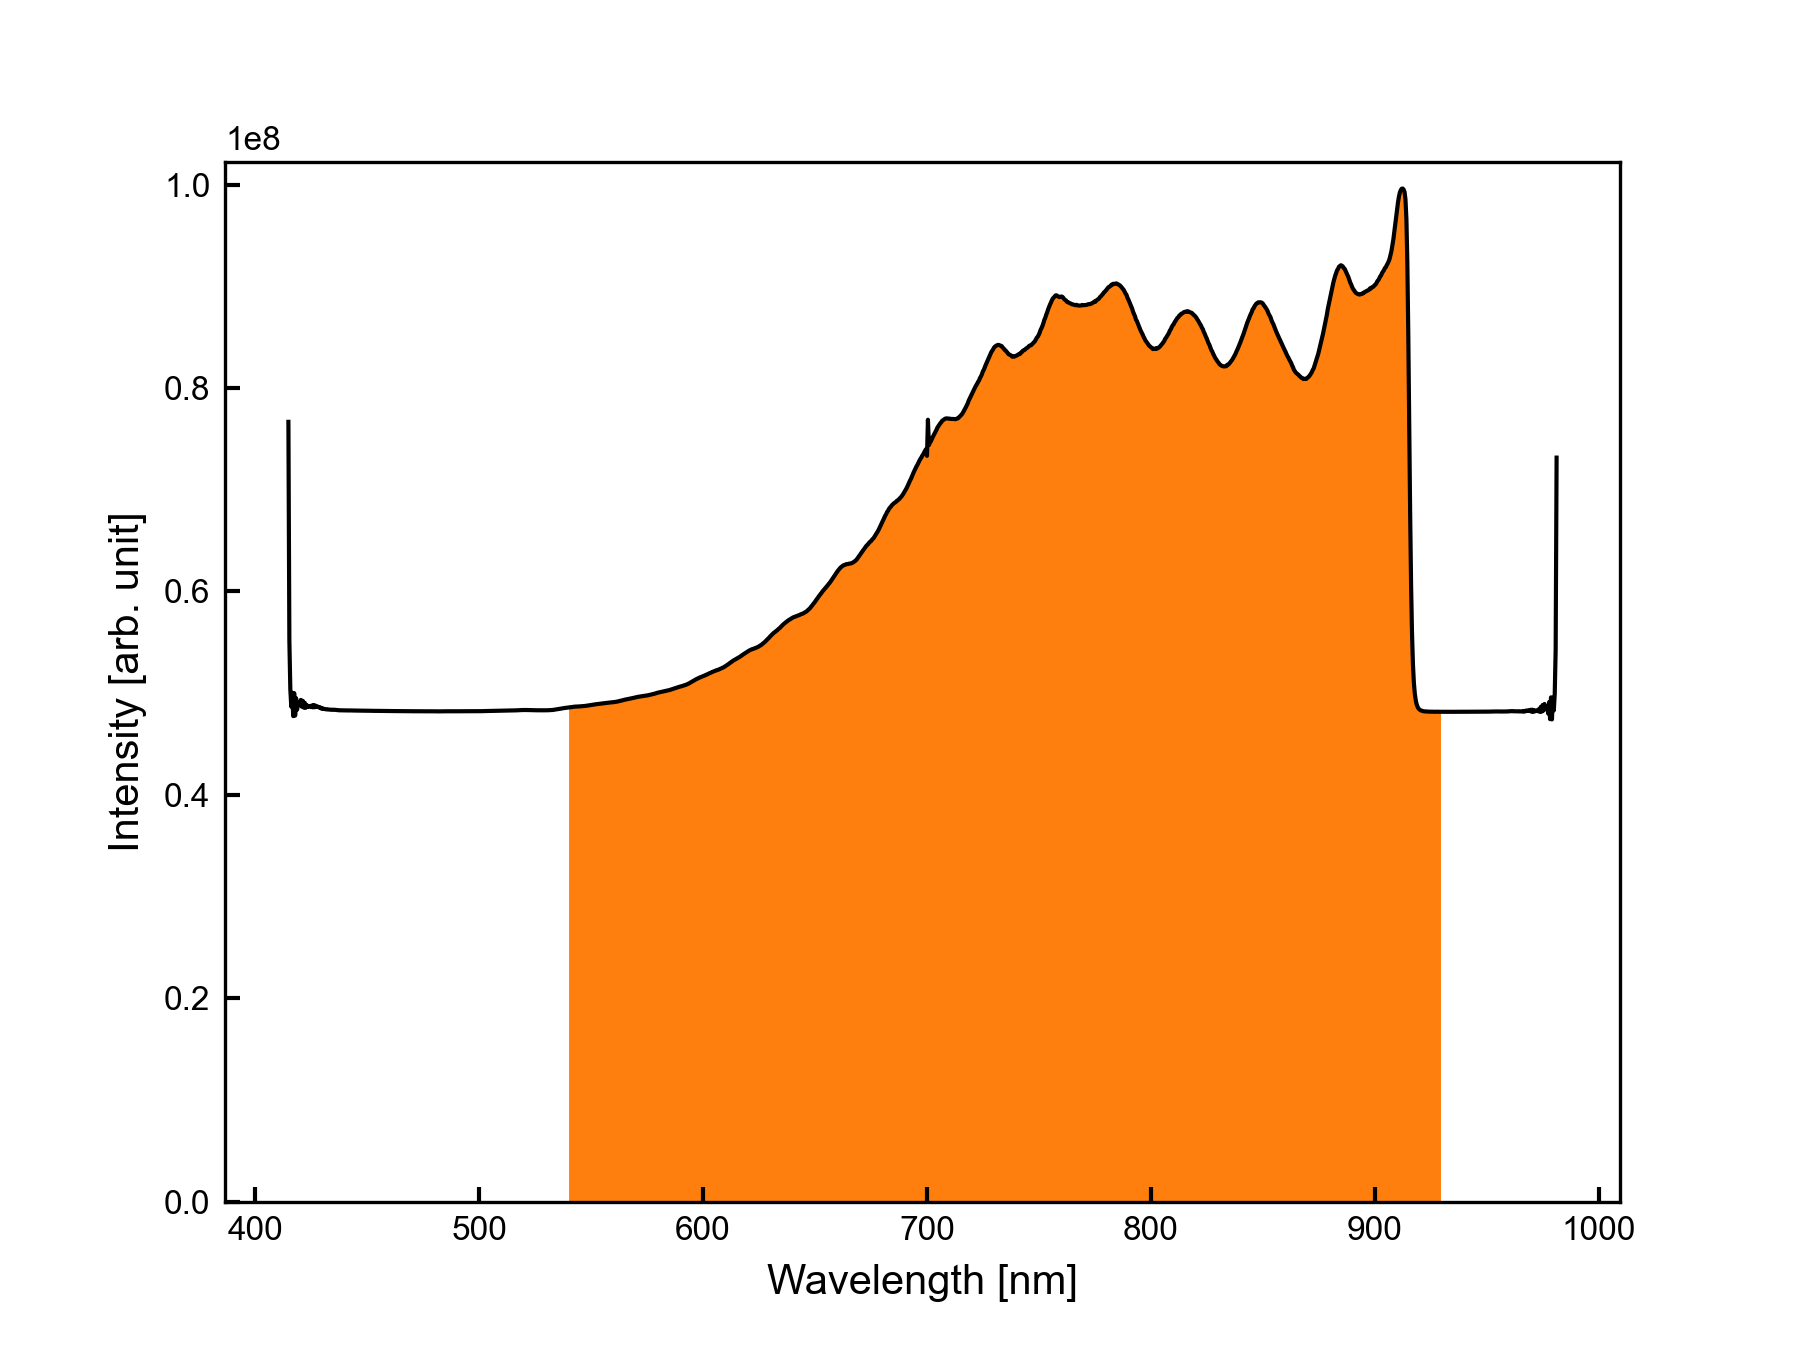


├── read_spe
│   └── hdffile <class 'str'>
├── add_calib
│   ├── OD
│   │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
│   │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
│   └── spectrum
│       └── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]
├── hist_intsty
│   └── threshold <class 'tuple'>
├── sum_wavelength
│   └── range <class 'tuple'>
└── make_mask_intsty
    └── mask <class 'numpy.ndarray'> [shape = (201, 400, 1340)]

In [18]:
def sum_wavelength():

    # wavelength領域
    wavelength_range = (600, 800) # nm
    wavelength_range = (600, 700) # nm
    wavelength_range = (540, 930) # nm

    if True:

        # データ読み込み
        with h5py.File(data["read_spe"]["hdffile"], mode = "r") as f:
            intsty = np.sum(np.array(f["data"][()]), axis = (0,1)) # type: ignore
            wavelength = np.array(f["wavelength"][()]) # type: ignore

        # 波長インデックス
        arg0 = np.argmin(np.abs(wavelength - wavelength_range[0]))
        arg1 = np.argmin(np.abs(wavelength - wavelength_range[1]))

        # figの定義
        fig, ax = plt.subplots()
        fig.set_size_inches((6,4.5))
        fig.set_dpi(300)

        # plot
        ax.plot(
            wavelength,
            intsty,
            lw = 1,
            c = "0"
        )
        ax.set_ylim((0, ax.get_ylim()[1]))
        ax.fill_between(
            wavelength[arg0:arg1],
            intsty[arg0:arg1],
            fc = "tab:orange"
        )
        
        ax.set_xlabel("Wavelength [nm]", fontsize = 10)
        ax.set_ylabel("Intensity [arb. unit]", fontsize = 10)

        # 画像の保存
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        key = sys._getframe().f_code.co_name
        imgfilename = cachedir + "/{}.png".format(key)
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
        # pdffilename = cachedir + "/{}.pdf".format(key)
        # plt.savefig(pdffilename)
        # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
        plt.close()

        # 変数の格納
        data[key] = dict()
        data[key]["range"] = (arg0, arg1)
        logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))

        # 出力
        display(Image(filename = imgfilename, width = 600))
        dict_tree(data)


    return
sum_wavelength()
del sum_wavelength

マスクを作成します。

In [19]:
def make_mask_intsty():

    # データ読み込み
    with h5py.File(data["read_spe"]["hdffile"], mode = "r") as f:
        intsty = np.array(f["data"][()]) # type: ignore

    # maskの作成
    intnsty_mask = np.zeros(intsty.shape).astype(np.bool_)
    intnsty_mask[:,:,data["sum_wavelength"]["range"][0]:data["sum_wavelength"]["range"][1]] = True
    intnsty_mask[intsty <= data["hist_intsty"]["threshold"][0]] = False
    intnsty_mask[intsty >= data["hist_intsty"]["threshold"][1]] = False

    # 変数の格納
    key = sys._getframe().f_code.co_name
    data[key] = dict()
    data[key]["mask"] = intnsty_mask
    logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
    dict_tree(data)

    return
make_mask_intsty()
del make_mask_intsty

INFO       2025-06-27 10:05:54,069 [4262524686.py:17] [Add variables]: make_mask_intsty (data = 102.75 MB)



├── read_spe
│   └── hdffile <class 'str'>
├── add_calib
│   ├── OD
│   │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
│   │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
│   └── spectrum
│       └── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]
├── hist_intsty
│   └── threshold <class 'tuple'>
├── sum_wavelength
│   └── range <class 'tuple'>
└── make_mask_intsty
    └── mask <class 'numpy.ndarray'> [shape = (201, 400, 1340)]

作成したマスクをアニメーションにします。

In [20]:
def mask_animation():

    # フレーム数
    n_frame = data["make_mask_intsty"]["mask"].shape[0]

    # 横軸
    with h5py.File(data["read_spe"]["hdffile"], mode = "r") as f:
        wavelength = np.array(f["wavelength"][()]) # type: ignore
    xlim = (wavelength[0], wavelength[-1])

    # 縦軸
    ylim = (0, data["make_mask_intsty"]["mask"].shape[1])

    # 軸
    extent: tuple = (*xlim, *ylim[::-1])

    # fig作成
    fig, ax = plt.subplots()
    fig.set_size_inches(6,4.5)

    # ax の設定
    ax.set_xlabel("Wavelength [nm]", fontsize = 10)
    ax.set_ylabel("Pixel", fontsize = 10)

    # animation
    ims = []
    for i in range(n_frame):
        # imshow
        imshow = ax.imshow(
            data["make_mask_intsty"]["mask"][i],
            aspect = "auto",
            cmap = "viridis",
            extent = extent,
        )

        # text
        tex = ax.text(
            x = 0,
            y = 1.01,
            s = "frame number = {:>4}".format(i),
            fontsize = 12,
            transform = ax.transAxes
        )

        # フレームに追加
        ims.append([imshow, tex])
        simple_progress_bar(i+1, n_frame)

    #. Save
    logger.debug("[Save]: Animation")
    ani = anim.ArtistAnimation(fig, ims, interval = 300)
    key = sys._getframe().f_code.co_name
    filename = os.path.join(cachedir, key + ".mp4")
    ani.save(filename, writer = "ffmpeg", fps = 30, dpi = 300)
    logger.info("[Save]: " + os.path.abspath(filename))

    plt.close()
    return
mask_animation()
del mask_animation

DEBUG      2025-06-27 10:05:56,227 [646891443.py:50] [Save]: Animation


Progress: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 100% (201/201) 


INFO       2025-06-27 10:06:25,589 [646891443.py:55] [Save]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\mask_animation.mp4


## 3. 校正

校正データを作成します。

In [21]:
def calibration():

    # データ読み込み
    with h5py.File(data["read_spe"]["hdffile"], mode = "r") as f:
        intsty = np.array(f["data"][()]) # type: ignore
        wavelength = np.array(f["wavelength"][()]) # type: ignore

    # スペクトルデータの補完
    spectrum_interp = sp.interpolate.interp1d(
        *data["add_calib"]["spectrum"]["csvdata"],
        kind = "cubic"
    )
    data["add_calib"]["spectrum"]["interp"] = spectrum_interp(wavelength)
    logger.debug("[Calc]: Interpolation of spectrum data")

    # 補正
    calibrated = dict()
    calibrated["wavelength"] = wavelength
    calibrated["data"] = (
        intsty
        * np.stack(
            [np.vstack(
                [data["add_calib"]["spectrum"]["interp"]]*intsty.shape[1]
            )]*intsty.shape[0],
            axis = 0
        )
        / np.stack(
            [np.vstack(
                [data["add_calib"]["OD"]["up"]]*(intsty.shape[1]//2)
                + [data["add_calib"]["OD"]["down"]]*(intsty.shape[1]//2)
            )]*intsty.shape[0],
            axis = 0
        )
    )
    logger.debug("[Calc]: Correction")

    # データ格納
    key = sys._getframe().f_code.co_name
    hdffile = os.path.join(cachedir, key+".hdf")
    with h5py.File(hdffile, mode = "w") as f:
        f.create_dataset(
            name = "data",
            data = calibrated["data"],
            dtype = np.float64,
        )
        f.create_dataset(
            name = "wavelength",
            data = calibrated["wavelength"],
            dtype = np.float64,
        )
        h5_tree(f)
    data[key] = dict()
    data[key]["hdffile"] = hdffile
    logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
    dict_tree(data)

    return
calibration()
del calibration

DEBUG      2025-06-27 10:06:52,210 [4063728594.py:14] [Calc]: Interpolation of spectrum data
DEBUG      2025-06-27 10:06:53,131 [4063728594.py:35] [Calc]: Correction
INFO       2025-06-27 10:06:53,908 [4063728594.py:54] [Add variables]: calibration (data = 102.75 MB)


<HDF5 file "calibration.hdf" (mode r+)>
├── data ((201, 400, 1340), float64)
└── wavelength ((1340,), float64)

├── read_spe
│   └── hdffile <class 'str'>
├── add_calib
│   ├── OD
│   │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
│   │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
│   └── spectrum
│       ├── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]
│       └── interp <class 'numpy.ndarray'> [shape = (1340,)]
├── hist_intsty
│   └── threshold <class 'tuple'>
├── sum_wavelength
│   └── range <class 'tuple'>
├── make_mask_intsty
│   └── mask <class 'numpy.ndarray'> [shape = (201, 400, 1340)]
└── calibration
    └── hdffile <class 'str'>

## 4. 計算範囲の設定

ピクセル範囲を設定します。

DEBUG      2025-06-27 10:08:40,281 [3153178653.py:84] [Save fig]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\set_range_pix.png
INFO       2025-06-27 10:08:40,283 [3153178653.py:93] [Add variablse]: set_range_pix (data = 102.75 MB)


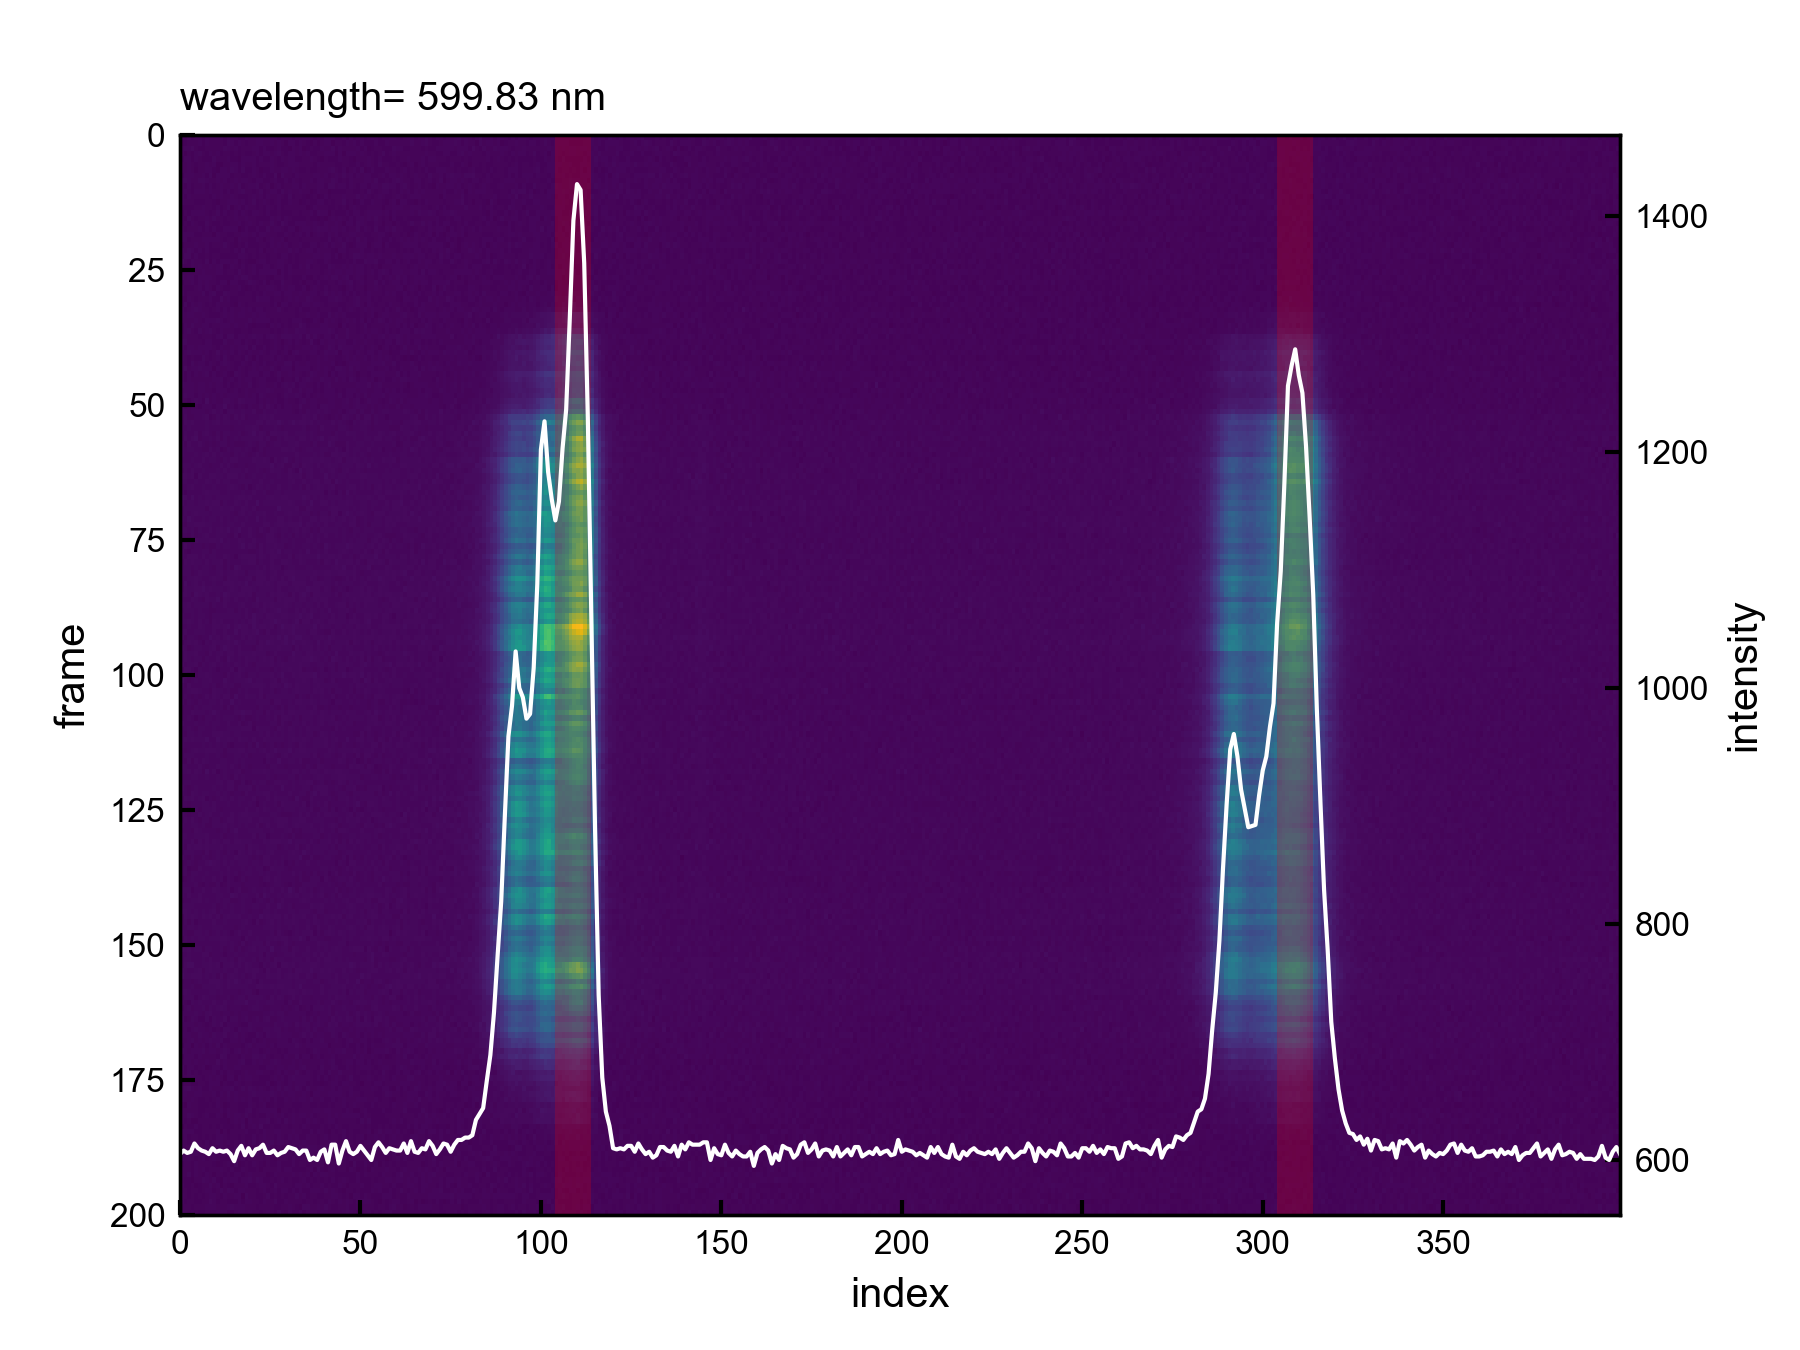


├── read_spe
│   └── hdffile <class 'str'>
├── add_calib
│   ├── OD
│   │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
│   │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
│   └── spectrum
│       ├── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]
│       └── interp <class 'numpy.ndarray'> [shape = (1340,)]
├── hist_intsty
│   └── threshold <class 'tuple'>
├── sum_wavelength
│   └── range <class 'tuple'>
├── make_mask_intsty
│   └── mask <class 'numpy.ndarray'> [shape = (201, 400, 1340)]
├── calibration
│   └── hdffile <class 'str'>
└── set_range_pix
    └── pix_range <class 'tuple'>

In [25]:
def set_range_pix():

    # pix ranges
    xrange = ((104,114), (304,314))

    # 参照する波長
    ref_wavelength = 600 # nm

    # 参照するフレーム
    ref_frame = 70

    if True: # Main
        """更新履歴
        * 2025/06/25: プロットの色を変更しました。
        """

        # データ読み込み
        with h5py.File(data["read_spe"]["hdffile"], mode = "r") as f:
            intsty = np.array(f["data"][()]) # type: ignore
            wavelength = np.array(f["wavelength"][()]) # type: ignore

        # 参照する波長データ
        arg_wavelength = np.argmin(np.abs(wavelength - ref_wavelength))

        # 強度時空間データ
        imshow = intsty.transpose(2,0,1)[arg_wavelength]

        # 強度空間データ
        plot = imshow[ref_frame]

        # figure作成
        fig = plt.figure()
        fig.set_size_inches(6,4.5)
        fig.set_dpi(300)

        # ax作成
        axs = []
        axs.append(fig.add_axes(rect = (0.1,0.1,0.8,0.8)))
        axs.append(axs[0].twinx())
        axs[0].set_xlabel("index", fontsize = 10)
        axs[0].set_ylabel("frame", fontsize = 10)
        axs[1].set_ylabel("intensity", fontsize = 10)
        axs[0].set_title(
            "wavelength= {:.2f} nm".format(wavelength[arg_wavelength]),
            loc = "left")

        # imshow
        axs[0].imshow(
            imshow,
            extent = (0, imshow.shape[1]-1,imshow.shape[0]-1, 0),
            aspect = "auto"
        )

        # plot
        axs[1].plot(
            np.arange(plot.shape[0]),
            plot,
            c = "1",
            lw = 1
        )
        axs[1].set_ylim(axs[1].get_ylim())

        # pixrangeを描写
        for i in range(2):
            axs[1].fill_betweenx(
                axs[1].get_ylim(),
                xrange[i][0],
                xrange[i][-1],
                fc = "red",
                alpha = 0.2,
            )

        # グラフ保存
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        key = sys._getframe().f_code.co_name
        imgfilename = cachedir + "/{}.png".format(key)
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
        # pdffilename = cachedir + "/{}.pdf".format(key)
        # plt.savefig(pdffilename)
        # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
        plt.close()

        # # データ格納
        data[key] = dict()
        data[key]["pix_range"] = xrange
        logger.info("[Add variablse]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
        display(Image(filename = imgfilename, width = 600))
        dict_tree(data)

    return
set_range_pix()
del set_range_pix

フレーム範囲を指定します。

DEBUG      2025-06-27 10:08:46,090 [3112726144.py:67] [Save fig]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\set_range_frame.png
INFO       2025-06-27 10:08:46,091 [3112726144.py:77] [Add variables]: set_range_frame (data = 102.75 MB)


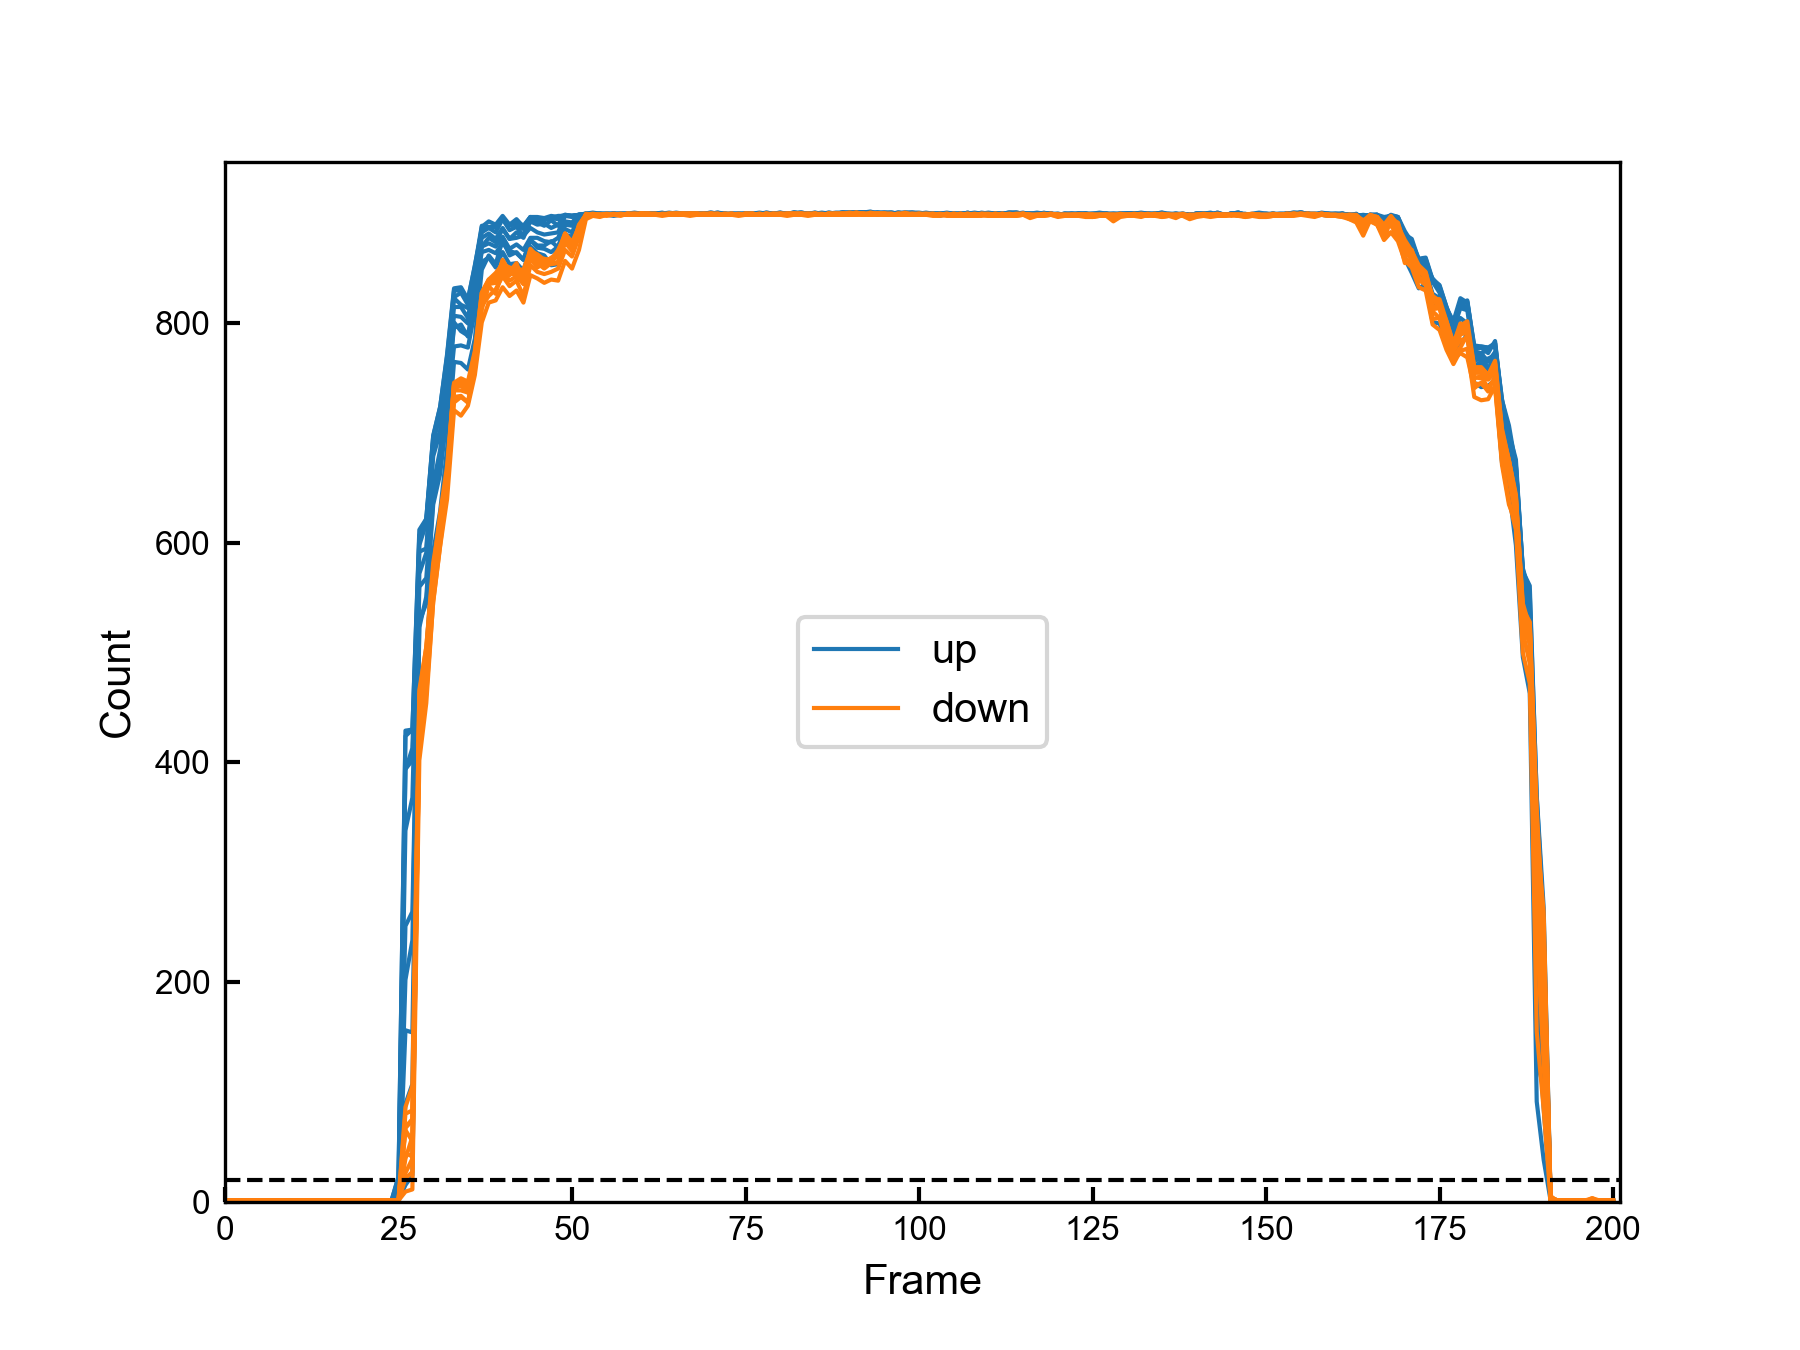


├── read_spe
│   └── hdffile <class 'str'>
├── add_calib
│   ├── OD
│   │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
│   │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
│   └── spectrum
│       ├── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]
│       └── interp <class 'numpy.ndarray'> [shape = (1340,)]
├── hist_intsty
│   └── threshold <class 'tuple'>
├── sum_wavelength
│   └── range <class 'tuple'>
├── make_mask_intsty
│   └── mask <class 'numpy.ndarray'> [shape = (201, 400, 1340)]
├── calibration
│   └── hdffile <class 'str'>
├── set_range_pix
│   └── pix_range <class 'tuple'>
└── set_range_frame
    └── threshold <class 'int'>

In [26]:
def set_range_frame():

    # 閾値
    count_threshold = 20

    if True:

        # データの読み込み
        up_masked = np.sum(data["make_mask_intsty"]["mask"].transpose(1,2,0)[data["set_range_pix"]["pix_range"][0][0]:data["set_range_pix"]["pix_range"][0][1]], axis = 1)
        down_masked = np.sum(data["make_mask_intsty"]["mask"].transpose(1,2,0)[data["set_range_pix"]["pix_range"][1][0]:data["set_range_pix"]["pix_range"][1][1]], axis = 1)

        # フレーム数
        n_frame = up_masked.shape[1]

        # figの作成
        fig, ax = plt.subplots()
        fig.set_size_inches((6,4.5))
        fig.set_dpi(300)

        # up
        for i in range(up_masked.shape[0]):
            ax.plot(
                np.arange(n_frame),
                up_masked[i],
                lw = 1,
                c = "tab:blue",
                label = None if i else "up"
            )

        # down
        for i in range(down_masked.shape[0]):
            ax.plot(
                np.arange(n_frame),
                down_masked[i],
                lw = 1,
                c = "tab:orange",
                label = None if i else "down"
            )

        # threshold
        ax.plot(
            [0, n_frame],
            [count_threshold]*2,
            c = "0",
            lw = 1,
            ls = "dashed"
        )

        # axの設定
        ax.legend(fontsize = 10)
        ax.set_xlim((0,n_frame))
        ax.set_ylim((0, ax.get_ylim()[-1]))
        ax.set_xlabel("Frame", fontsize = 10)
        ax.set_ylabel("Count", fontsize = 10)

        # 画像の保存
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        key = sys._getframe().f_code.co_name
        imgfilename = cachedir + "/{}.png".format(key)
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
        # pdffilename = cachedir + "/{}.pdf".format(key)
        # plt.savefig(pdffilename)
        # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
        plt.close()

        # データ格納
        key = sys._getframe().f_code.co_name
        data[key] = dict()
        data[key]["threshold"] = count_threshold
        logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))

        # 出力
        display(Image(filename = imgfilename, width = 600))
        dict_tree(data)

    return
set_range_frame()
del set_range_frame

## 5. 計算データの作成

計算用のデータを作成します。

In [27]:
def get_valid():

    # データ読み込み
    with h5py.File(data["calibration"]["hdffile"], mode = "r") as f:
        intsty = np.array(f["data"][()]) # type: ignore
        wavelength = np.array(f["wavelength"][()]) # type: ignore

    # フレーム数
    n_frame = intsty.shape[0]
    
    # 格納変数の定義
    valid_data = dict()

    # up and down
    for i, stream in enumerate(["up", "down"]):
        valid_data[stream] = dict()
        for pix in range(*data["set_range_pix"]["pix_range"][i]):

            # each pix
            valid_data[stream]["pix = {}".format(pix)] = dict()
            for j in range(n_frame):

                # データの選択
                intdata = intsty[j][pix]
                maskdata = data["make_mask_intsty"]["mask"][j][pix]

                if (np.sum(maskdata) > data["set_range_frame"]["threshold"]):
                    data_masked = intdata[maskdata]
                    wavelength_masked = wavelength[maskdata]
                    valid_data[stream]["pix = {}".format(pix)]["frame = {}".format(j)] = dict()
                    valid_data[stream]["pix = {}".format(pix)]["frame = {}".format(j)]["data"] = data_masked
                    valid_data[stream]["pix = {}".format(pix)]["frame = {}".format(j)]["wavelength"] = wavelength_masked
                else:
                    valid_data[stream]["pix = {}".format(pix)]["frame = {}".format(j)] = None
    logger.info("[Calc]: valid_data (size = {:.2f} MB)".format(get_total_size(valid_data)/1024/1024))

    # データ格納
    key = sys._getframe().f_code.co_name
    data[key] = dict()
    data[key]["data"] = [valid_data]
    logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))

    # 出力
    dict_tree(data)    

    return
get_valid()
del get_valid

INFO       2025-06-27 10:08:51,510 [41636476.py:35] [Calc]: valid_data (size = 44.44 MB)
INFO       2025-06-27 10:08:51,516 [41636476.py:41] [Add variables]: get_valid (data = 147.19 MB)



├── read_spe
│   └── hdffile <class 'str'>
├── add_calib
│   ├── OD
│   │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
│   │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
│   └── spectrum
│       ├── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]
│       └── interp <class 'numpy.ndarray'> [shape = (1340,)]
├── hist_intsty
│   └── threshold <class 'tuple'>
├── sum_wavelength
│   └── range <class 'tuple'>
├── make_mask_intsty
│   └── mask <class 'numpy.ndarray'> [shape = (201, 400, 1340)]
├── calibration
│   └── hdffile <class 'str'>
├── set_range_pix
│   └── pix_range <class 'tuple'>
├── set_range_frame
│   └── threshold <class 'int'>
└── get_valid
    └── data <class 'list'>

## 6. 温度計算

In [28]:
import threading
import concurrent.futures as confu

温度計算をします

In [29]:
def calc_temp():

    # keyリストの作成
    key_list = []
    for stream in data["get_valid"]["data"][0].keys():
        for pix in data["get_valid"]["data"][0][stream].keys():
            for frame in data["get_valid"]["data"][0][stream][pix].keys():
                key_list.append(dict({
                    "stream": stream,
                    "pix": pix,
                    "frame": frame
                }))

    # 出力格納用変数の定義
    key = sys._getframe().f_code.co_name
    hdffilename = os.path.join(cachedir, key+".hdf")

    # ファイルテンプレート作成（最初に1回だけ）
    with h5py.File(hdffilename, mode="w") as f:
        for stream in data["get_valid"]["data"][0].keys():
            g = f.create_group(name = stream)
            for pix in data["get_valid"]["data"][0][stream].keys():
                gg = g.create_group(pix)
                for frame in data["get_valid"]["data"][0][stream][pix].keys():
                    ggg  = gg.create_group(frame)
                    if data["get_valid"]["data"][0][stream][pix][frame] is not None:
                        length = data["get_valid"]["data"][0][stream][pix][frame]["wavelength"].shape[0]
                        ggg.create_dataset(
                            name = "wavelength",
                            data = data["get_valid"]["data"][0][stream][pix][frame]["wavelength"],
                            dtype = np.float64,
                            shape = (length,)
                        )
                        ggg.create_dataset(
                            name = "data",
                            dtype = np.float64,
                            shape = (length*(length-1)/2,)
                        )
    logger.debug("Template file created: " + os.path.abspath(hdffilename))
    print_fileinfo(hdffilename)

    # lock
    lock = threading.Lock()

    # 関数の定義
    def process(i_process):

        # key
        stream = key_list[i_process]["stream"]
        pix = key_list[i_process]["pix"]
        frame = key_list[i_process]["frame"]

        # 例外処理
        if data["get_valid"]["data"][0][stream][pix][frame] is None:
            return i_process, None

        # data attraction
        i = data["get_valid"]["data"][0][stream][pix][frame]["data"]
        w = data["get_valid"]["data"][0][stream][pix][frame]["wavelength"]
        mask = ~np.tril(np.ones([w.shape[0]]*2)).astype(np.bool_)

        # 波長の計算
        wset = np.stack(np.meshgrid(*([w]*2)), axis = -1)[mask].T
        lnW = np.log(wset[0]/wset[1])
        invW = (np.reciprocal(wset[0]) - np.reciprocal(wset[1]))

        # 強度の計算
        iset = np.stack(np.meshgrid(*([i]*2)), axis = -1)[mask].T
        lnR = np.log(iset[0]/iset[1])

        # 温度を算出
        constant = 1e9 # nm -> m
        temperature = -sp.constants.h*sp.constants.c/sp.constants.Boltzmann*constant * invW / (lnR + 5 * lnW)
        
        return i_process, temperature
    logger.debug("Define the function")

    # 演算
    with confu.ThreadPoolExecutor() as tpe:

        # 演算指示
        futures = [tpe.submit(process, i_process) for i_process in range(len(key_list))]

        # 終わったプロセスから順に出力
        for i, future in enumerate(confu.as_completed(futures)):
            
            # データ読み込み
            i_process, temp = future.result()

            # 例外処理
            if temp is None:
                continue

            # key 決定
            stream = key_list[i_process]["stream"]
            pix = key_list[i_process]["pix"]
            frame = key_list[i_process]["frame"]

            # 書き換え
            with lock:
                with h5py.File(hdffilename, mode = "r+") as f:
                    f[stream][pix][frame]["data"][:] = temp # type: ignore
            simple_progress_bar(i+1, len(key_list))

    
    # データ格納
    key = sys._getframe().f_code.co_name
    data[key] = dict()
    data[key]["hdffile"] = hdffilename
    logger.info("[Add variablse]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
    dict_tree(data)

    return
calc_temp()
del calc_temp

DEBUG      2025-06-27 10:08:57,690 [1266764683.py:39] Template file created: c:\Users\okaza\pythonenv\lf\twocolor\.cache\calc_temp.hdf
DEBUG      2025-06-27 10:08:57,691 [1266764683.py:76] Define the function



File name: c:\Users\okaza\pythonenv\lf\twocolor\.cache\calc_temp.hdf
File size: 28,669,272 bites
Last update time: 2025-06-27 10:08:57.689642

Progress: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■-] 100% (4016/4020) 

INFO       2025-06-27 10:09:49,313 [1266764683.py:110] [Add variablse]: calc_temp (data = 147.19 MB)


Progress: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 100% (4020/4020) 

├── read_spe
│   └── hdffile <class 'str'>
├── add_calib
│   ├── OD
│   │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
│   │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
│   └── spectrum
│       ├── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]
│       └── interp <class 'numpy.ndarray'> [shape = (1340,)]
├── hist_intsty
│   └── threshold <class 'tuple'>
├── sum_wavelength
│   └── range <class 'tuple'>
├── make_mask_intsty
│   └── mask <class 'numpy.ndarray'> [shape = (201, 400, 1340)]
├── calibration
│   └── hdffile <class 'str'>
├── set_range_pix
│   └── pix_range <class 'tuple'>
├── set_range_frame
│   └── threshold <class 'int'>
├── get_valid
│   └── data <class 'list'>
└── calc_temp
    └── hdffile <class 'str'>

## 7. 計算結果の出力

各ピクセルに対して時系列データを出力します。

In [30]:
def hist_temp():

    # 温度範囲
    tlim = (1000, 2500)

    # step
    step = 200

    # グラフサイズ
    size_inches = (6,4.5)

    # aset
    aset = 1000

    if True: # Main
            
        # ディレクトリ作成
        key = sys._getframe().f_code.co_name
        dir = os.path.join(cachedir, key)
        os.makedirs(dir, exist_ok=True)

        # bins
        bins = np.linspace(*tlim, step)
        center = (bins[:-1] + bins[1:])/2

        # データ格納用
        histdata = dict()
        histdata["bins"] = center
        histdata["data"] = dict()

        # 次のセッション用
        fulllength = dict()
        counts = dict()

        # グラフ作成
        for stream in data["get_valid"]["data"][0].keys():
            for pix in data["get_valid"]["data"][0][stream].keys():

                # imgファイルを作成する
                filename = stream + "_" + pix[6:]
                fulllength[filename] = []
                counts[filename] = []

                # データフォルダを用意する
                _histdata = []

                # fig作成
                fig, ax = plt.subplots()
                fig.set_size_inches(size_inches)
                fig.set_dpi(300)

                # ax設定
                ax.autoscale(tight = True)
                ax.set_xlabel("Temperature [K]", fontsize = 10)
                ax.set_ylabel("Count", fontsize = 10)
                ax.set_xlim(tlim)

                # hdfを開く
                with h5py.File(data["calc_temp"]["hdffile"], mode = "r") as f:
                    for i, frame in tqdm(enumerate(data["get_valid"]["data"][0][stream][pix].keys())):
                        # 例外処理
                        try:
                            temp = np.array(f[stream][pix][frame]["data"][()]) # type: ignore
                        except:
                            temp = []
                        
                        # ヒストグラム
                        hist, _ = np.histogram(temp, bins = bins)
                        _histdata.append(hist)

                        # 集計
                        fulllength[filename].append(len(temp))
                        counts[filename].append(np.sum(hist))

                        # plot
                        ax.plot(
                            center,
                            hist + i*aset,
                            lw = 0.1,
                            c = "0",
                        )

                # グラフ保存
                fig.canvas.draw()
                img = im.frombuffer(
                    mode = "RGBA",
                    size = fig.canvas.get_width_height(),
                    data = fig.canvas.buffer_rgba(), # type: ignore
                    decoder_name = "raw"
                )
                key = sys._getframe().f_code.co_name
                imgfilename = os.path.join(dir, filename + ".png")
                img.save(imgfilename)
                logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
                pdffilename = os.path.join(dir, filename + ".pdf")
                plt.savefig(pdffilename)
                logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
                plt.close()
                
                # データを格納
                histdata["data"][filename] = np.vstack(_histdata)
                fulllength[filename] = np.array(fulllength[filename])
                counts[filename] = np.array(counts[filename])

        # 集計データをhdfファイルに保存
        hdffilename = os.path.join(cachedir, key + ".hdf")
        with h5py.File(hdffilename, mode = "w") as f:
            f.create_dataset(
                name = "bins",
                data = histdata["bins"],
                dtype = np.float64
            )
            g = f.create_group(
                name = "data"
            )
            for key_hist in histdata["data"].keys():
                g.create_dataset(
                    name = key_hist,
                    data = histdata["data"][key_hist],
                    dtype = np.float64
                )
            h5_tree(f)

        # データ格納
        data[key] = dict()
        data[key]["tlim"] = tlim
        data[key]["step"] = step
        data[key]["size_inches"] = size_inches
        data[key]["aset"] = aset
        data[key]["hdffile"] = hdffilename
        data[key]["fulllength"] = [fulllength]
        data[key]["counts"] = [counts]
        logger.info("[Add variablse]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
        dict_tree(data)

    return
hist_temp()
del hist_temp

201it [00:01, 197.46it/s]
DEBUG      2025-06-27 10:10:54,136 [3786686733.py:94] [Save fig]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\hist_temp\up_104.png
DEBUG      2025-06-27 10:10:54,498 [3786686733.py:97] [Save fig]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\hist_temp\up_104.pdf
201it [00:00, 203.48it/s]
DEBUG      2025-06-27 10:10:55,591 [3786686733.py:94] [Save fig]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\hist_temp\up_105.png
DEBUG      2025-06-27 10:10:55,723 [3786686733.py:97] [Save fig]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\hist_temp\up_105.pdf
201it [00:00, 234.95it/s]
DEBUG      2025-06-27 10:10:56,682 [3786686733.py:94] [Save fig]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\hist_temp\up_106.png
DEBUG      2025-06-27 10:10:56,813 [3786686733.py:97] [Save fig]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\hist_temp\up_106.pdf
201it [00:00, 231.44it/s]
DEBUG      2025-06-27 10:10:57,787 [3786686733.py:94] [Save fig]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\

<HDF5 file "hist_temp.hdf" (mode r+)>
├── bins ((199,), float64)
└── data
    ├── down_304 ((201, 199), float64)
    ├── down_305 ((201, 199), float64)
    ├── down_306 ((201, 199), float64)
    ├── down_307 ((201, 199), float64)
    ├── down_308 ((201, 199), float64)
    ├── down_309 ((201, 199), float64)
    ├── down_310 ((201, 199), float64)
    ├── down_311 ((201, 199), float64)
    ├── down_312 ((201, 199), float64)
    ├── down_313 ((201, 199), float64)
    ├── up_104 ((201, 199), float64)
    ├── up_105 ((201, 199), float64)
    ├── up_106 ((201, 199), float64)
    ├── up_107 ((201, 199), float64)
    ├── up_108 ((201, 199), float64)
    ├── up_109 ((201, 199), float64)
    ├── up_110 ((201, 199), float64)
    ├── up_111 ((201, 199), float64)
    ├── up_112 ((201, 199), float64)
    └── up_113 ((201, 199), float64)

├── read_spe
│   └── hdffile <class 'str'>
├── add_calib
│   ├── OD
│   │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
│   │   └── down <class 'numpy.ndarray

温度プロファイルを動画にします。

In [31]:
def anim_tempprofile():

    stream = dict()
    index = dict()

    with h5py.File(data["hist_temp"]["hdffile"], mode = "r") as f:
        bins = np.array(f["bins"][()]) # type: ignore
        for pix in f["data"].keys(): # type: ignore
            for st in ["up", "down"]:
                if st in pix:
                    if not st in stream.keys():
                        stream[st] = []
                    stream[st].append(f["data"][pix][()]) # type: ignore

                    if not st in index.keys():
                        index[st] = []
                    index[st].append(int(pix.replace(st + "_", "")))
        for st in ["up", "down"]:
            stream[st] = np.stack(stream[st], axis = -1)

    # フレーム数        
    n_frame = stream["up"].shape[0]

    # ピクセル幅
    pix_width = abs(index["up"][0]-index["up"][1])

    # 温度幅
    bin_width = abs(bins[0] - bins[1])

    # fig作成
    fig, axs = plt.subplots(1,2)
    fig.set_size_inches((8,6))
    fig.set_dpi(300)

    # axsの設定
    axs[0].set_title("up stream", fontsize = 12, loc = "left")
    axs[1].set_title("down stream", fontsize = 12, loc = "left")

    # 0番目のフレーム
    ims = [None]*2
    for i, st in enumerate(["up", "down"]):
        ims[i] = axs[i].imshow(
            stream[st][0],
            aspect = "auto",
            extent = (
                min(index[st]) - pix_width/2,
                max(index[st]) + pix_width/2,
                min(bins) - bin_width/2,
                max(bins) + bin_width/2
            ),
            origin = "lower",
            vmax = stream[st].max(),
            vmin = stream[st].min(),
        )
    ims.append(axs[0].text(
        x = 0,
        y = 1.07,
        s = "frame = {:>4}".format(0),
        fontsize = 12,
        transform = axs[0].transAxes
    ))    

    # フレームを変更する関数
    def update(frame):
        for i, st in enumerate(["up", "down"]):
            ims[i].set_data(stream[st][frame]) # type: ignore
        ims[2].set_text("frame = {:>4}".format(frame)) # type: ignore
        return ims

    # アニメ作成
    ani = anim.FuncAnimation(fig, update, frames=n_frame) # type: ignore
    plt.close()

    #. Save
    logger.debug("[Save]: Animation")
    key = sys._getframe().f_code.co_name
    filename = os.path.join(cachedir, key + ".mp4")
    ani.save(filename, writer = "ffmpeg", fps = 30, dpi = 300)
    logger.info("[Save]: " + os.path.abspath(filename))

    return
anim_tempprofile()
del anim_tempprofile

DEBUG      2025-06-27 10:11:31,403 [2491350810.py:75] [Save]: Animation
INFO       2025-06-27 10:12:07,016 [2491350810.py:79] [Save]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\anim_tempprofile.mp4


## 8. フィッティング

フィッティングする領域を決定します。

In [ ]:
def set_fitlim():

    # フレームレンジ
    framelim = (5, 96)

    # legned
    # legend = True

    if True:

        # 例外処理
        if not ("legend" in locals()):
            legend = False

        # データ長の計測
        n_frame = data["make_mask_intsty"]["mask"].shape[0]
        keys = []
        for stream in data["get_valid"]["data"][0].keys():
            for pix in data["get_valid"]["data"][0][stream].keys():
                keys.append(stream + "_" + pix[6:])

        # fig
        fig = plt.figure()
        fig.set_size_inches((6,5))
        fig.set_dpi(300)

        ax_count = fig.add_subplot(2,1,1)
        ax_rate = fig.add_subplot(2,1,2)

        for k in keys:
            ax_count.plot(
                np.arange(n_frame),
                data["hist_temp"]["fulllength"][0][k],
                lw = 0.5,
                label = k
            )
            ful = data["hist_temp"]["fulllength"][0][k].copy()
            ful[ful == 0] = 1
            ax_rate.plot(
                np.arange(n_frame),
                data["hist_temp"]["counts"][0][k]/ful,
                lw = 0.5,
                label = k
            )
        
        ax_rate.set_xlabel("frame", fontsize = 10)
        ax_rate.set_ylim((0,1))
        for ax in [ax_count, ax_rate]:
            ax.autoscale(axis = "x", tight = True)
            if legend:
                ax.legend(fontsize = 6)
            ax.set_ylim(ax.get_ylim())
            ax.vlines(
                x = framelim,
                ymin = [ax.get_ylim()[0]]*2,
                ymax = [ax.get_ylim()[1]]*2,
                lw = 0.5,
                colors = "0",
                linestyles="dashed"
            )

        # グラフ保存
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        key = sys._getframe().f_code.co_name
        imgfilename = os.path.join(cachedir, key + ".png")
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))      
        # pdffilename = os.path.join(cachedir, key + ".pdf")
        # plt.savefig(pdffilename)
        # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
        plt.close()

        # データ格納
        data[key] = dict()
        data[key]["lim"] = framelim
        logger.info("[Add variablse]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))

        # 出力
        display(Image(filename = imgfilename, width = 600))
        dict_tree(data)


    return
set_fitlim()
del set_fitlim

フィッティングします

In [ ]:
def autofit():

    # 温度データを読み込み
    with h5py.File(data["hist_temp"]["hdffile"], mode = "r") as f:
        temp = np.array(f["bins"][()]) # type: ignore
        key_data = list(f["data"].keys())  # type: ignore
        countdata = np.stack([f["data"][key][()] for key in key_data], axis = 0)  # type: ignore
    n_frame = countdata.shape[1]

    # 出力格納用変数を定義
    res = [None]*n_frame

    # フィット用関数を定義
    pf = peakfit()
    def process(_i, _data):
        if (_i >= data["set_fitlim"]["lim"][0]) * (_i <= data["set_fitlim"]["lim"][1]):
            _res = pf.fit_Vigot_func(
                theta = temp,
                intensity = _data[_i]
            )
            if type(_res) is RuntimeError:
                return _i, None
            res_dict = dict()
            for j, k in enumerate(["popt", "pcov"]):
                res_dict[k] = dict()
                for l, m in enumerate(pf.variables(nop = 1)):
                    res_dict[k][m] = _res[j][l]
            res_dict["r2"] = _res[2]
            return _i, res_dict
        else:
            return _i, None

    # ディレクトリを用意する
    key = sys._getframe().f_code.co_name
    dir = os.path.join(cachedir, key)
    os.makedirs(dir, exist_ok=True)

    # データ格納
    data[key] = dict()

    for i, k in enumerate(key_data):
        # マルチスレッドを使いながら演算
        with confu.ThreadPoolExecutor() as tpe:
            futures = [tpe.submit((lambda j: process(j, countdata[i])), i_frame) for i_frame in np.arange(n_frame)]
            for l, future in enumerate(confu.as_completed(futures)):
                i_frame, val = future.result()
                if not (val is None):
                    res[i_frame] = val # type: ignore
                simple_progress_bar(l+1, n_frame)

        jsonfile = os.path.join(dir, k+".json")
        with open(jsonfile, mode = "w") as f:
            json.dump(res, f, indent = 4)
        logger.info("[Save json]: " + os.path.abspath(jsonfile))
        data[key][k] = jsonfile
    
    logger.info("[Add variablse]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))    
    dict_tree(data)

    return
autofit()
del autofit

フィッティング結果を表示します。

In [ ]:
def plot_res():

    # データ読み込み
    tlim = data["hist_temp"]["tlim"]
    step = data["hist_temp"]["step"]
    size_inches = data["hist_temp"]["size_inches"]
    aset = data["hist_temp"]["aset"]

    # bins
    with h5py.File(data["hist_temp"]["hdffile"], mode = "r") as f:
        center = np.array(f["bins"][()]) # type: ignore
            
    # ディレクトリ作成
    key = sys._getframe().f_code.co_name
    dir = os.path.join(cachedir, key)
    os.makedirs(dir, exist_ok=True)

    # グラフ作成
    pf = peakfit()
    for stream in data["get_valid"]["data"][0].keys():
        for pix in data["get_valid"]["data"][0][stream].keys():

            # imgファイルを作成する
            filename = stream + "_" + pix[6:]
            logger.debug("filename = " + filename)

            # fig作成
            fig, ax = plt.subplots()
            fig.set_size_inches(size_inches)
            fig.set_dpi(300)

            # ax設定
            ax.autoscale(tight = True)
            ax.set_xlabel("Temperature [K]", fontsize = 10)
            ax.set_ylabel("Count", fontsize = 10)
            ax.set_xlim(tlim)

            # hist data
            with h5py.File(data["hist_temp"]["hdffile"], mode = "r") as f:
                hists = np.array(f["data"][filename][()]) # type: ignore

            # plot
            with open(data["autofit"][filename]) as f:
                res_fit = json.load(f)
            for i in range(hists.shape[0]):
                # 生データ
                ax.plot(
                    center,
                    hists[i] + i*aset,
                    lw = 0.1,
                    c = "0",
                )

                if res_fit[i] is not None:
                    y: np.ndarray = pseudoVoigt(
                        center,
                        *[res_fit[i]["popt"][j] for j in pf.variables()]
                    ) # type: ignore
                    ax.plot(
                        center,
                        y + i*aset,
                        lw = 0.1,
                        c = "tab:orange"
                    )
                    ax.plot(
                        [res_fit[i]["popt"]["mu"]],
                        [
                            res_fit[i]["popt"]["amp"]
                            + res_fit[i]["popt"]["b0"]
                            + res_fit[i]["popt"]["b1"] * res_fit[i]["popt"]["mu"]
                            + i*aset
                        ],
                        lw = 0,
                        marker = "o",
                        ms = 1,
                        mec = "tab:orange",
                        c = "1",
                        mew = 0.1
                    )
                

            # グラフ保存
            fig.canvas.draw()
            img = im.frombuffer(
                mode = "RGBA",
                size = fig.canvas.get_width_height(),
                data = fig.canvas.buffer_rgba(), # type: ignore
                decoder_name = "raw"
            )
            key = sys._getframe().f_code.co_name
            imgfilename = os.path.join(dir, filename + ".png")
            img.save(imgfilename)
            logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
            pdffilename = os.path.join(dir, filename + ".pdf")
            plt.savefig(pdffilename)
            logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
            plt.close()

    return
plot_res()
del plot_res

## csv出力

温度データを1次元データにします。

In [ ]:
def temp_1d():

    csvdata = dict()
    
    for stream in data["get_valid"]["data"][0].keys():
        for pix in data["get_valid"]["data"][0][stream].keys():

            # imgファイルを作成する
            filename = stream + "_" + pix[6:]
            logger.debug("filename = " + filename)
            csvdata[filename] = []
            csvdata["e_" + filename] = []

            # jsonファイル読み込み
            with open(data["autofit"][filename]) as f:
                res_fit = json.load(f)
            
            for i in range(len(res_fit)):
                try:
                    csvdata[filename].append(res_fit[i]["popt"]["mu"])
                except:
                    csvdata[filename].append(300)
                    csvdata["e_" + filename].append(0)
                else:
                    n = data["hist_temp"]["counts"][0][filename][i]
                    fwhm_g = res_fit[i]["popt"]["fwhm_g"]
                    fwhm_l = res_fit[i]["popt"]["fwhm_l"]
                    eta = res_fit[i]["popt"]["eta"]
                    err = fwhm_g*eta + fwhm_l*(1-eta)
                    csvdata["e_" + filename].append(err/np.sqrt(n))

    
    # データ保存
    key = sys._getframe().f_code.co_name
    csvfile = os.path.join(cachedir, key + ".csv")
    pd.DataFrame(csvdata).to_csv(csvfile)
    logger.info("[Save csv]: " + csvfile)

    # データ格納
    data[key] = dict()
    data[key]["csv"] = csvfile
    logger.info("[Add variablse]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))    
    dict_tree(data)    

    return
temp_1d()
del temp_1d

1次元データをグラフにします。

In [ ]:
def plot_csv():

    # データ読み込み
    csvdata = pd.read_csv(data["temp_1d"]["csv"])
    n_frame = data["make_mask_intsty"]["mask"].shape[0]

    # ファイル名定義
    keys = []
    for stream in data["get_valid"]["data"][0].keys():
        for pix in data["get_valid"]["data"][0][stream].keys():
            keys.append(stream + "_" + pix[6:])

    # fig作成
    fig, ax = plt.subplots()
    fig.set_size_inches((6,4.5))
    fig.set_dpi(300)

    # plot
    for k in keys:
        ax.errorbar(
            np.arange(n_frame),
            csvdata[k],
            yerr = csvdata["e_" + k],
            lw = 0,
            label = k,
            fmt = "o",
            ms = 1,
            mew = 0.2,
            mfc = "1",
            elinewidth=0.2
        )

    # axの設定
    ax.autoscale(axis = "x", tight=True)
    ax.set_ylim(data["hist_temp"]["tlim"])
    ax.legend(fontsize = 6)
    ax.set_xlabel("frame", fontsize = 10)
    ax.set_ylabel("Tempeature [K]", fontsize = 10)
    
    
    # グラフ保存
    fig.canvas.draw()
    img = im.frombuffer(
        mode = "RGBA",
        size = fig.canvas.get_width_height(),
        data = fig.canvas.buffer_rgba(), # type: ignore
        decoder_name = "raw"
    )
    key = sys._getframe().f_code.co_name
    imgfilename = os.path.join(cachedir, key + ".png")
    img.save(imgfilename)
    logger.debug("[Save fig]: " + os.path.abspath(imgfilename))      
    # pdffilename = os.path.join(cachedir, key + ".pdf")
    # plt.savefig(pdffilename)
    # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
    plt.close()

    # 出力
    display(Image(filename = imgfilename, width = 600))


    return
plot_csv()
del plot_csv